In [44]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer 
  
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from nltk import FreqDist
from itertools import chain

import nltk
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/jayiraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/jayiraj/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jayiraj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Business Understanding

As Data Scientists at Apple, we are attempting to leverage sentiment of tweets, particularly tweets related to Apple and Google at a SXSW (South By Southwest) event, to enhance our social media engagement, as well as our general marketing and advertising strategies. SXSW is is an annual festival/conference event held in Austin, Texas. We aim to assess our product marketing effectiveness to inform future strategies, ensuring our approach is both data-driven and responsive to consumer trends. This analysis will help us identify areas of improvement in our products and services, as well as opportunities for innovation.

By proactively addressing these concerns, we can demonstrate our commitment to customer satisfaction and product improvement. Additionally, we will be able to spot emerging trends and topics in real-time, allowing us to engage with our audience more effectively and participate in relevant conversations. 

# Data Understanding

The data we are using was taken from [data.world](https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv). It contains 9,093 tweets that mention SXSW and mention different companies and/or its products. Each row represents a tweet, and there are three columns: one dispaying the tweet text itself, one that labels the product or company the sentiment in the tweet is directed at, and one that tells us whether the tweet showed a positive emotion, negative emotion, neutral emotion, or undetermined. These emotion labels were crowdsourced.

In [45]:
#Importing our dataset

df= pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [46]:
#Exploring the first 5 rows

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


# Data Cleaning and Preprocessing

In [48]:
# Renaming the columns for simplicity
df = df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'products',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'
})

df.head()

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [49]:
#Renaming the emotions labels for simplcity

df['emotions'] = df['emotions'].replace('No emotion toward brand or product', 'Neutral')
df['emotions'] = df['emotions'].replace('Positive emotion', 'Positive')
df['emotions'] = df['emotions'].replace('Negative emotion', 'Negative')

In [50]:
#Dropping the tweets where the emotion was 'I can't tell'

df = df[df['emotions'].isin(['Neutral', 'Negative', 'Positive'])]

In [51]:
df['emotions'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotions, dtype: int64

In [52]:
df.isna().sum()

tweet_text       1
products      5655
emotions         0
dtype: int64

In [53]:
#Dropping the row with the one null value in the 'tweet_text' column

df = df.dropna(subset=['tweet_text'])

In [54]:
df.isna().sum()

tweet_text       0
products      5654
emotions         0
dtype: int64

In [55]:
# Bringing in stopwords

sw = stopwords.words('english')

## NLP and Tweet-specific preprocessing

Because we are working with text, specifically tweets, we need to do some additional cleaning and preprocessing. Particularly, we will get rid of stopwords (words that will appear frequently in our text but provide no semantic value). We also need to lemmatize our words to normalize them, get rid of any punctuation, lowercase our words, and tokenize them so that our data is divided by the individual words. We will also need to vectorize our text data, converting to numerical vectors.

In [56]:
# Add custom words to the stopword list
# These words appear frequently in our data and provide no semantic value
custom_stopwords = ['sxsw', 'mention','link','rt', 'for','quot']

# Extend the NLTK stopword list with custom stopwords
sw.extend(custom_stopwords)

In [57]:
#Part of speech tags that will help our lemmatizer work.
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [58]:
#Instantiating our lemmatizer

lemmatizer = WordNetLemmatizer() 

We will now create a function that takes our tweet text, lemmatizes our words, lowercases them, gets rid of stopwords, and strips our text of punctuation and numbers. Later on, we will feed our doc_preparer to our vectorizer in our model pipelines to preprocess our text before it is vectorized and used in our modeling.

In [59]:
def doc_preparer(doc, stop_words=sw):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokens = regex_token.tokenize(doc)
    lowered_t = [word.lower() for word in tokens]
    no_sw_t = [word for word in lowered_t if word not in sw]
    # print(doc)
    tokens_tagged = pos_tag(no_sw_t)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged] 
    tokens_lemm = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    return ' '.join(tokens_lemm)

In [60]:
#MOVE THIS AFTER OUR MODELING

# Create a new column in your DataFrame for the preprocessed text
df['preprocessed_text'] = df['tweet_text'].apply(lambda x: doc_preparer(x))

# Now you can perform EDA on 'preprocessed_text'
# For example, token frequency analysis
from collections import Counter
all_words = ' '.join(df['preprocessed_text']).split()
word_freq = Counter(all_words)


# Word Frequency By Target

MOVE THIS SECTION TO AFTER OUR MODELING

In [61]:
positive_df = df[df['emotions']=='Positive']
neutral_df = df[df['emotions']== 'Neutral']
negative_df = df[df['emotions']=='Negative']

In [62]:
neutral_df

,tweet_text,products,emotions,preprocessed_text
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral,teachntech new ipad apps speechtherapy communi...
16,Holler Gram for iPad on the iTunes App Store -...,NaN,Neutral,holler gram ipad itunes app store http co kfn ...
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,Neutral,attn frineds register gdgtlive see cobra irada...
33,Anyone at #sxsw want to sell their old iPad?,NaN,Neutral,anyone want sell old ipad
34,Anyone at #SXSW who bought the new iPad want ...,NaN,Neutral,anyone buy new ipad want sell old ipad
...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,Neutral,yup third app yet android suggestion cc
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral,wave buzz interrupt regularly schedule geek pr...
9090,"Google's Zeiger, a physician never reported po...",NaN,Neutral,google zeiger physician never report potential...
9091,Some Verizon iPhone customers complained their...,NaN,Neutral,verizon iphone customer complain time fell bac...


In [63]:
positive_words = ' '.join(positive_df['preprocessed_text']).split()

# Compute the frequency distribution
pos_freq_dist = FreqDist(positive_words)

# Display the most common words
print(pos_freq_dist.most_common(50))

[('ipad', 1249), ('apple', 937), ('google', 736), ('store', 562), ('iphone', 551), ('app', 401), ('new', 361), ('austin', 297), ('get', 292), ('pop', 217), ('amp', 211), ('android', 211), ('launch', 195), ('go', 184), ('open', 180), ('win', 156), ('party', 154), ('one', 151), ('line', 147), ('come', 144), ('time', 141), ('great', 139), ('via', 132), ('day', 128), ('free', 126), ('social', 124), ('use', 124), ('circle', 124), ('cool', 122), ('like', 120), ('map', 120), ('today', 114), ('see', 113), ('good', 111), ('love', 109), ('w', 108), ('check', 102), ('mobile', 102), ('sxswi', 97), ('awesome', 95), ('look', 95), ('network', 93), ('make', 89), ('temporary', 89), ('downtown', 88), ('people', 83), ('apps', 83), ('u', 77), ('popup', 77), ('even', 73)]


In [64]:
neutral_words = ' '.join(neutral_df['preprocessed_text']).split()

# Compute the frequency distribution
neut_freq_dist = FreqDist(neutral_words)

# Display the most common words
print(neut_freq_dist.most_common(50))

[('google', 1733), ('ipad', 1501), ('apple', 1249), ('store', 899), ('iphone', 843), ('new', 680), ('austin', 634), ('amp', 601), ('launch', 593), ('circle', 512), ('social', 503), ('today', 441), ('pop', 366), ('network', 362), ('app', 360), ('android', 359), ('get', 359), ('open', 329), ('call', 304), ('via', 282), ('line', 282), ('free', 262), ('go', 261), ('mobile', 242), ('party', 241), ('sxswi', 231), ('major', 230), ('check', 197), ('possibly', 191), ('come', 181), ('make', 178), ('see', 177), ('u', 175), ('temporary', 170), ('win', 155), ('w', 149), ('time', 145), ('use', 143), ('map', 143), ('mayer', 140), ('like', 140), ('design', 140), ('one', 139), ('know', 139), ('day', 138), ('need', 138), ('downtown', 136), ('say', 134), ('popup', 131), ('talk', 129)]


In [65]:
negative_words = ' '.join(negative_df['preprocessed_text']).split()

# Compute the frequency distribution
neg_freq_dist = FreqDist(negative_words)

# Display the most common words
print(neg_freq_dist.most_common(50))

[('ipad', 211), ('iphone', 166), ('google', 152), ('apple', 123), ('app', 60), ('store', 47), ('new', 45), ('like', 43), ('get', 42), ('circle', 37), ('need', 35), ('go', 32), ('social', 31), ('design', 30), ('apps', 30), ('people', 29), ('launch', 29), ('austin', 28), ('think', 28), ('android', 24), ('use', 24), ('take', 24), ('look', 24), ('line', 23), ('one', 23), ('time', 23), ('come', 22), ('amp', 22), ('day', 22), ('say', 21), ('call', 21), ('today', 21), ('fail', 20), ('would', 19), ('see', 18), ('news', 18), ('give', 18), ('pop', 18), ('good', 18), ('network', 18), ('long', 18), ('phone', 18), ('make', 18), ('year', 17), ('headache', 17), ('battery', 17), ('product', 17), ('talk', 17), ('user', 16), ('wait', 16)]


In [66]:
pos_documents = positive_df['preprocessed_text']
pos_tfidf_vectorizer = TfidfVectorizer()
pos_tfidf_matrix = pos_tfidf_vectorizer.fit_transform(pos_documents)

pos_feature_names = pos_tfidf_vectorizer.get_feature_names()
pos_feature_names
pos_tfidf_scores = pos_tfidf_matrix.mean(axis=0).A1

pos_tfidf_df = pd.DataFrame({'Word': pos_feature_names, 'Positive TF-IDF Score': pos_tfidf_scores})
pos_tfidf_df = pos_tfidf_df.sort_values(by='Positive TF-IDF Score', ascending=False)

print(pos_tfidf_df.head(50)) 

#pos_tfidf_scores


           Word  Positive TF-IDF Score
1884       ipad               0.051810
165       apple               0.048227
3429      store               0.035139
1514     google               0.034988
1887     iphone               0.029093
158         app               0.024743
2434        new               0.022915
230      austin               0.021643
1469        get               0.020174
2738        pop               0.017853
2526       open               0.016348
2035     launch               0.015894
128     android               0.015218
1496         go               0.014502
4015        win               0.014474
122         amp               0.013966
2092       line               0.013074
3907        via               0.012632
2608      party               0.012402
2521        one               0.012234
678        come               0.011998
613      circle               0.011132
3681       time               0.011027
759        cool               0.010880
1546      great          

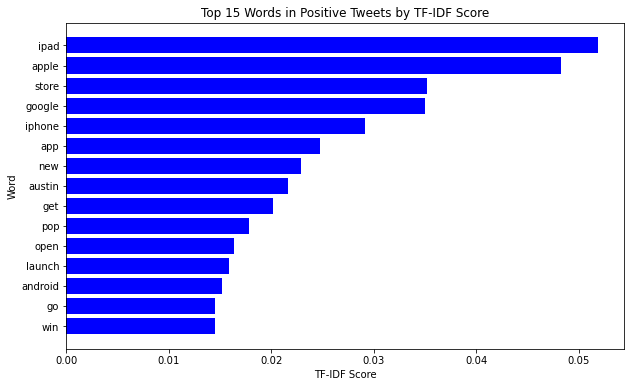

In [67]:

# Get the top 15 terms and scores
p_top_terms = pos_tfidf_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(p_top_terms['Word'], p_top_terms['Positive TF-IDF Score'], color='blue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Positive Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

In [68]:
neut_documents = neutral_df['preprocessed_text']
neut_tfidf_vectorizer = TfidfVectorizer()
neut_tfidf_matrix = neut_tfidf_vectorizer.fit_transform(neut_documents)

neut_feature_names = neut_tfidf_vectorizer.get_feature_names()
neut_tfidf_scores = neut_tfidf_matrix.mean(axis=0).A1

neut_tfidf_df = pd.DataFrame({'Word': neut_feature_names, 'Neutral TF-IDF Score': neut_tfidf_scores})
neut_tfidf_df = neut_tfidf_df.sort_values(by='Neutral TF-IDF Score', ascending=False)

print(neut_tfidf_df.head(50)) 

           Word  Neutral TF-IDF Score
2181     google              0.045073
232       apple              0.041290
2667       ipad              0.040956
4872      store              0.035034
2886     launch              0.026663
3440        new              0.026190
2671     iphone              0.025424
338      austin              0.025278
900      circle              0.024632
4706     social              0.023099
5218      today              0.020048
174         amp              0.019936
3897        pop              0.019434
3435    network              0.019349
3596       open              0.017592
738        call              0.016203
227         app              0.014592
2126        get              0.014498
183     android              0.014397
2971       line              0.014308
5519        via              0.014024
3093      major              0.013674
3922   possibly              0.011961
2162         go              0.011589
2002       free              0.011474
3296     mob

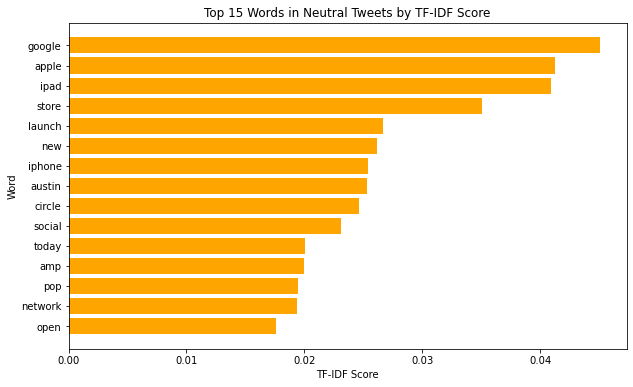

In [69]:
import matplotlib.pyplot as plt

# Get the top 15 terms and scores
neutral_top_terms = neut_tfidf_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(neutral_top_terms['Word'], neutral_top_terms['Neutral TF-IDF Score'], color='orange')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Neutral Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

In [70]:
neg_documents = negative_df['preprocessed_text']
neg_tfidf_vectorizer = TfidfVectorizer()
neg_tfidf_matrix = neg_tfidf_vectorizer.fit_transform(neg_documents)

neg_feature_names = neg_tfidf_vectorizer.get_feature_names()
neg_tfidf_scores = neg_tfidf_matrix.mean(axis=0).A1

neg_tfidf_df = pd.DataFrame({'Word': neg_feature_names, 'Negative TF-IDF Score': neg_tfidf_scores})
neg_tfidf_df = neg_tfidf_df.sort_values(by='Negative TF-IDF Score', ascending=False)

print(neg_tfidf_df.head(50)) 

          Word  Negative TF-IDF Score
803       ipad               0.051201
807     iphone               0.042071
660     google               0.039108
76       apple               0.035982
72         app               0.023019
1456     store               0.018800
1017       new               0.016882
242     circle               0.016610
881       like               0.016608
642        get               0.015943
388     design               0.015260
1407    social               0.014395
1008      need               0.013514
80        apps               0.013511
651         go               0.013469
861     launch               0.013144
1111    people               0.012549
1533     think               0.012446
96      austin               0.012027
54     android               0.011446
901       look               0.011415
885       line               0.011273
706   headache               0.010829
1622       use               0.010820
1502      take               0.010468
1545      ti

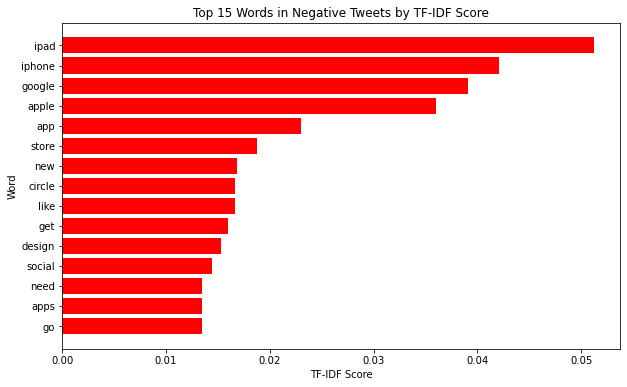

In [71]:

# Get the top 15 terms and scores
n_top_terms = neg_tfidf_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(n_top_terms['Word'], n_top_terms['Negative TF-IDF Score'], color='red')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Negative Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

In [72]:
all_words = ' '.join(df['preprocessed_text']).split()

# Compute the frequency distribution
freq_dist = FreqDist(all_words)

# Display the most common words
print(freq_dist.most_common(50))

[('ipad', 2961), ('google', 2621), ('apple', 2309), ('iphone', 1560), ('store', 1508), ('new', 1086), ('austin', 959), ('amp', 834), ('app', 821), ('launch', 817), ('get', 693), ('circle', 673), ('social', 658), ('pop', 601), ('android', 594), ('today', 576), ('open', 520), ('go', 477), ('network', 473), ('line', 452), ('via', 428), ('party', 401), ('call', 395), ('free', 390), ('mobile', 357), ('come', 347), ('sxswi', 340), ('win', 313), ('one', 313), ('time', 309), ('see', 308), ('check', 305), ('like', 303), ('major', 303), ('use', 291), ('day', 288), ('make', 285), ('map', 273), ('w', 269), ('u', 266), ('temporary', 264), ('need', 240), ('possibly', 240), ('look', 233), ('great', 226), ('people', 226), ('design', 225), ('downtown', 225), ('apps', 223), ('mayer', 219)]


In [73]:
df

,tweet_text,products,emotions,preprocessed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,wesley g iphone hr tweet rise austin dead need...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,jessedee know fludapp awesome ipad iphone app ...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,swonderlin wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,sxtxstate great stuff fri marissa mayer google...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive,ipad everywhere
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral,wave buzz interrupt regularly schedule geek pr...
9090,"Google's Zeiger, a physician never reported po...",NaN,Neutral,google zeiger physician never report potential...
9091,Some Verizon iPhone customers complained their...,NaN,Neutral,verizon iphone customer complain time fell bac...


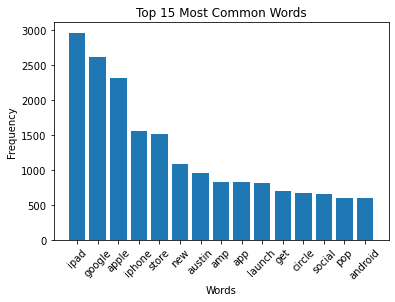

In [74]:
import matplotlib.pyplot as plt

# Get the most common words and their counts
common_words = freq_dist.most_common(15)
words, counts = zip(*common_words)

# Create a bar chart
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Common Words')
plt.xticks(rotation=45)
plt.show()

# Modeling

We will now create predictive models with our data, using the words in the tweet texts to predict sentiment. We will create predictive models with our binomial classification (positive and negative emotion) as well as with our multi-class target (positive, negative, and neutral). Before doing so, we will train_test_split our data and create pipelines for some of our models. We will focus on Multinomial Naive Bayes and Random Forest for our modeling. Once we find our best-performing model on cross validation, we will run further analysis on its most important features.

## Splitting our Data

In [75]:
X = df['tweet_text'] 
y = df['emotions'] 

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Multiclass Multinomial Naive Bayes Model

### Pipeline

In [77]:
#Multinomial Naive Bayes Pipeline

#Instantiating our Tfidf vectorizer with our preprocessor in the pipeline

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('nb', MultinomialNB())
])

### Grid Searching 

In [78]:
#Grid Search Parameters for Bayes

nb_param_grid = {
    'tfidf__max_df': [0.75],
    'tfidf__min_df': [.01,.05,.1],
    'tfidf__ngram_range': [(1, 2)],
}

In [79]:
#Running our naive bayes grid search with the pipeline and grid parameters

nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=3, n_jobs=1, verbose=2)

#Fitting on our training data

nb_grid_search.fit(X_train, y_train) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.1, tfid

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.7s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7fee6a97bc10>)),
                                       ('nb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'tfidf__max_df': [0.75],
                         'tfidf__min_df': [0.01, 0.05, 0.1],
                         'tfidf__ngram_range': [(1, 2)]},
             verbose=2)

In [82]:
# Evaluation for Naive Bayes cross-val performance

nb_best_model = nb_grid_search.best_estimator_
print("Best Parameters for Naive Bayes:", nb_grid_search.best_params_)
print("Grid Search Best Score:", nb_grid_search.best_score_)

#Accuracy Score on Training

print("Accuracy Score on Training:", nb_best_model.score(X_train, y_train))

Best Parameters for Naive Bayes: {'tfidf__max_df': 0.75, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}
Grid Search Best Score: 0.6333242664037727
Accuracy Score on Training: 0.6484331281477337


## Multiclass Random Forest Model

### Pipeline

In [90]:
#Random Forest Pipeline

#Instantiating our Tfidf vectorizer with our preprocessor in the pipeline


rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('rf', RandomForestClassifier())])

### Grid Searching

In [110]:
#Grid Search Parameters for Random Forest

rf_param_grid = {
    'tfidf__max_df': [.6, .8, .9],
    'tfidf__min_df': [1, 5],
    'tfidf__ngram_range': [(1, 1)],
    'rf__n_estimators': [150], 
    'rf__max_depth': [None, 70, 120],
 'rf__min_samples_split':[3,4,5],
   'rf__min_samples_leaf':[1,2],
'rf__max_features': [95, 100, 105],
'rf__class_weight': [None, 'balanced']}

In [111]:
# Running our random forest grid search with pipeline and param grid

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, n_jobs=1, verbose=2)

#Fitting on our training data

rf_grid_search.fit(X_train, y_train) 

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.7s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.7s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_d

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__m

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.0s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__m

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__m

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__m

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__m

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.6s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfi

[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfi

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfi

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfi

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfi

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfi

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfi

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8

[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.7s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.5s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.8s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=None, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimato

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.1s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.0s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.3s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=70, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.6s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.7s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=95, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tf

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.4s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.2s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.7s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.6, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.6s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   5.1s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=3, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   5.3s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.9s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=15

[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1), total=   4.8s
[CV] rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=balanced, rf__max_depth=120, rf__max_features=105, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=15

[Parallel(n_jobs=1)]: Done 1944 out of 1944 | elapsed: 152.0min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7fee6a97bc10>)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=1,
             param_grid={'rf__class_weight': [None, 'balanced'],
                         'rf__max_depth': [None, 70, 120],
                         'rf__max_features': [95, 100, 105],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [3, 4, 5],
                         'rf__n_estimators': [150],
                         'tfidf__max_df': [0.6, 0.8, 0.9],
                         'tfidf__min_df': [1, 5],
                         'tfidf__ngram_range': [(1, 1)]},
             verbose=2)

In [112]:
#Evaluation for Random Forest cross validation

rf_best_model = rf_grid_search.best_estimator_
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Grid Search Best Score:", rf_grid_search.best_score_)

#Accuracy Score on Training

print("Accuracy Score on Training:", rf_best_model.score(X_train, y_train))

Best Parameters for Random Forest: {'rf__class_weight': None, 'rf__max_depth': 120, 'rf__max_features': 100, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 150, 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Grid Search Best Score: 0.6856460287142143
Accuracy Score on Training: 0.8978735310576385


## Best Model Evaluation

We will now take our best model on cross validation (multiclass random forest) and predict on the test set. We can then plot a confusion matrix to see how it is predicting each class.

In [105]:
y_pred_rf = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy Score on Test set", rf_accuracy)


Accuracy Score on Test set 0.6907158836689038


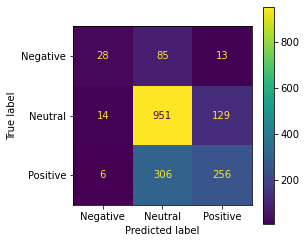

In [106]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= rf_best_model.classes_).plot(ax=ax)

# Show the plot
plt.show()

# Features Importance Analysis

In [73]:
rf_tfidf_vectorizer = rf_best_model.named_steps['tfidf']
rf_tfidf_feature_names = rf_tfidf_vectorizer.get_feature_names()
rf_tfidf_feature_importances = rf_tfidf_vectorizer.idf_

In [74]:
rf_model = rf_best_model.named_steps['rf']
rf_feature_importances = rf_model.feature_importances_

In [114]:
feature_importance_df = pd.DataFrame({'Feature': rf_tfidf_feature_names, 'Importance': rf_feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(50)) 

       Feature  Importance
3155      ipad    0.017192
281      apple    0.013287
2556    google    0.011467
3159    iphone    0.011032
5781     store    0.010348
274        app    0.008106
403     austin    0.006874
210        amp    0.006679
4055       new    0.006678
2493       get    0.005514
3416    launch    0.005185
4597       pop    0.005119
1277      cool    0.005011
3506      like    0.004974
2117      fail    0.004913
4439    people    0.004735
2602     great    0.004675
1042    circle    0.004643
2750  headache    0.004611
3517      line    0.004436
223    android    0.004320
4239      open    0.004229
5842      suck    0.004102
6203     today    0.004044
2349      free    0.003936
5576    social    0.003931
1559    design    0.003799
4379     party    0.003750
451    awesome    0.003731
4029      need    0.003714
2531        go    0.003671
4224       one    0.003640
6132     think    0.003545
6757       win    0.003491
3576      look    0.003475
3596      love    0.003455
3

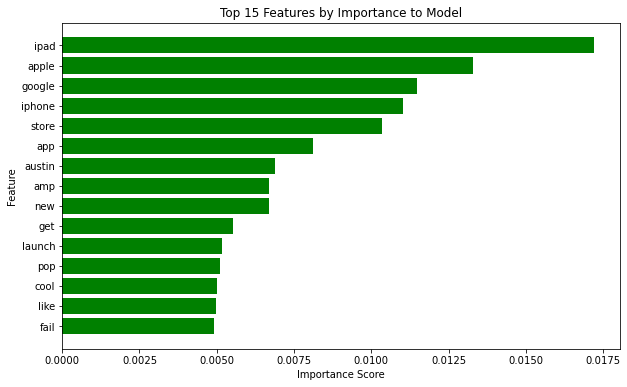

In [160]:
# Get the top 15 features and their importance scores
top_features = feature_importance_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='green')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 15 Features by Importance to Model')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest importance at the top
plt.show()

In [48]:
documents = df['preprocessed_text']
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

feature_names = tfidf_vectorizer.get_feature_names()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

tfidf_df = pd.DataFrame({'Term': feature_names, 'TF-IDF Score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='TF-IDF Score', ascending=False)

print(tfidf_df.head(50)) 

           Term  TF-IDF Score
3482       ipad    393.706915
310       apple    376.081488
2822     google    359.336209
6395      store    299.138856
3489     iphone    239.375512
4510        new    213.162008
441      austin    204.370285
3787     launch    195.979945
1157     circle    174.148013
6181     social    162.560269
300         app    161.070850
5116        pop    160.827025
228         amp    151.833258
4718       open    144.916383
2748        get    143.244584
6863      today    141.818031
4503    network    134.492131
242     android    125.641611
3896       line    120.142966
7258        via    114.108774
953        call    112.411049
2794         go    109.715918
4059      major     95.048426
4874      party     94.983691
2586       free     91.938646
6706  temporary     90.543664
4321     mobile     90.078535
6568      sxswi     84.255925
7479        win     83.082897
1268       come     83.020958
1093      check     81.569801
5147   possibly     80.422134
1935   dow